In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, K, N, P, NORMALIZE_FLAGS    

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-03 23:01:49,246 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
2025-01-03 23:01:49,247 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
2025-01-03 23:01:49,247 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


In [2]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)


[   30    63    90 ... 99871 99921 99960]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


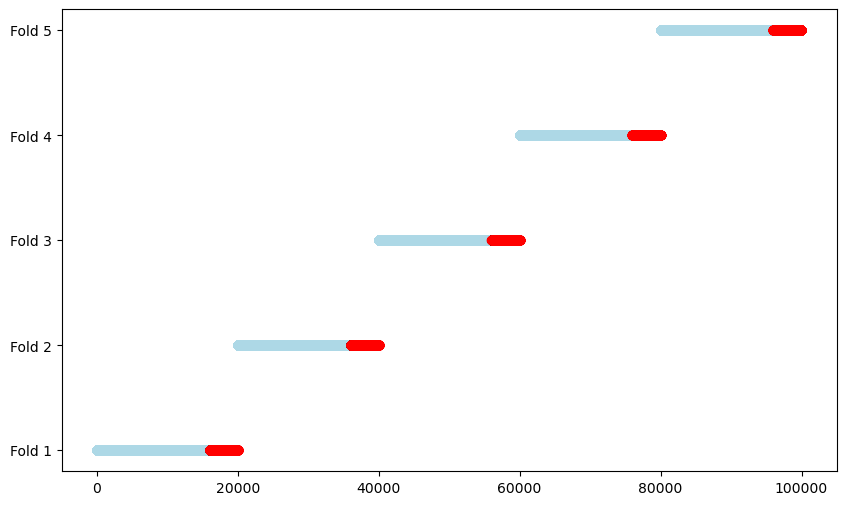

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19972, 100, 3])
X_mask shape: torch.Size([19972, 100])
X_indices shape: torch.Size([19972, 4, 1])
y shape: torch.Size([19972, 1])


Number of finished trials:  100
Best trial: 91
Best hyperparameters: {'learning_rate': 0.0005373221661425615, 'num_layers': 3, 'kernel_size': 3, 'pool_size': None, 'batch_size': 32, 'num_filters_layer_0': 32, 'num_filters_layer_1': 64, 'num_filters_layer_2': 32}
Validation Losses: [44.895, 47.508, 49.281, 50.664, 44.665]
Mean validation loss: 47.403
Test Losses: [67.831, 66.696, 68.134, 64.012, 76.565]
Mean test loss: 68.648
Mean test MAE: 6.271 std: 0.191
Mean test RMSE: 8.282 std: 0.251


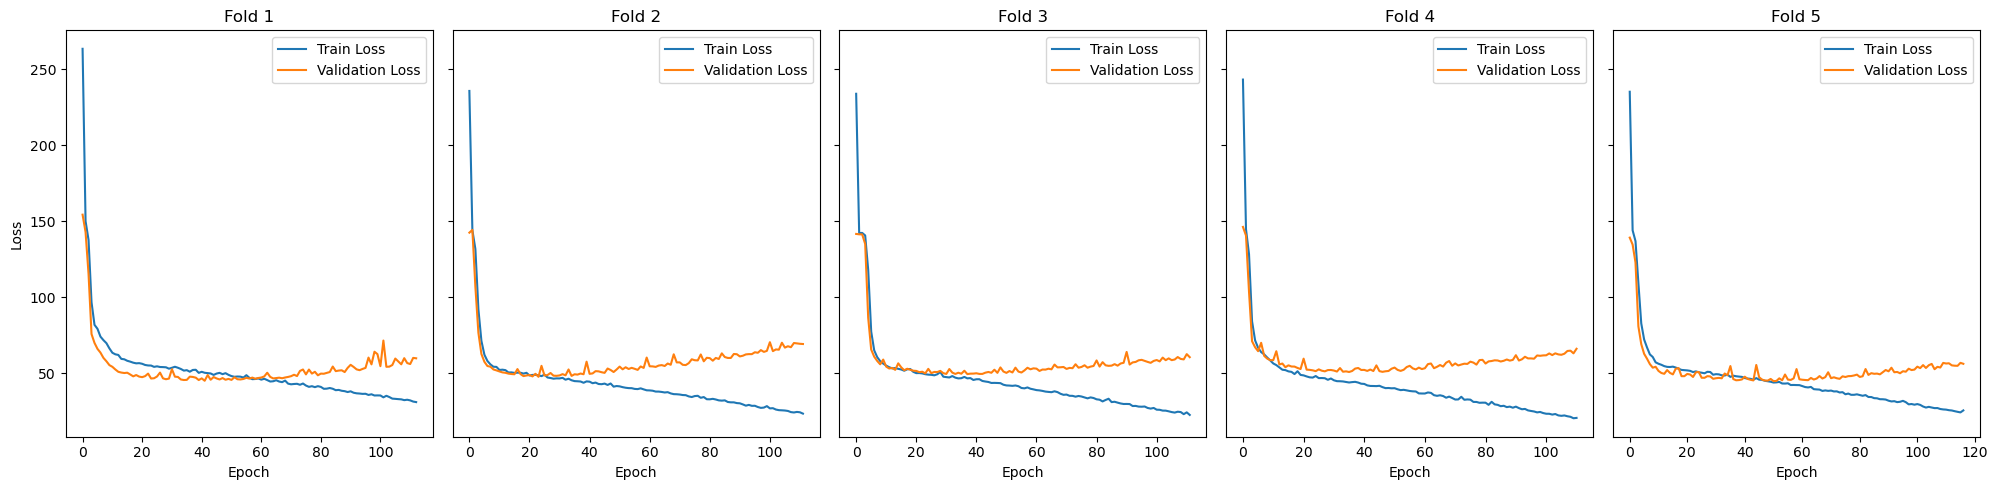

In [6]:
from models.cnn_pytorch import CNN
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None, 2, 3]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

X = {"X_series": X_series}
#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

Best hyperparameters: {'learning_rate': 0.0005373221661425615, 'num_layers': 3, 'kernel_size': 3, 'pool_size': None, 'batch_size': 32, 'num_filters_layer_0': 32, 'num_filters_layer_1': 64, 'num_filters_layer_2': 32}


Early stopping at epoch 113, with best epoch being 41
Early stopping at epoch 112, with best epoch being 23
Early stopping at epoch 112, with best epoch being 37
Early stopping at epoch 111, with best epoch being 35
Early stopping at epoch 117, with best epoch being 50
Validation Losses: [44.91306552886963, 47.48598747253418, 49.279333400726316, 50.67694988250732, 44.67177357673645]
Mean validation loss: 47.40542197227478
Test Losses: [67.81288528442383, 66.73455993652344, 68.1641488647461, 63.96513877868652, 76.58604309082031]
Mean test loss: 68.65255519104005


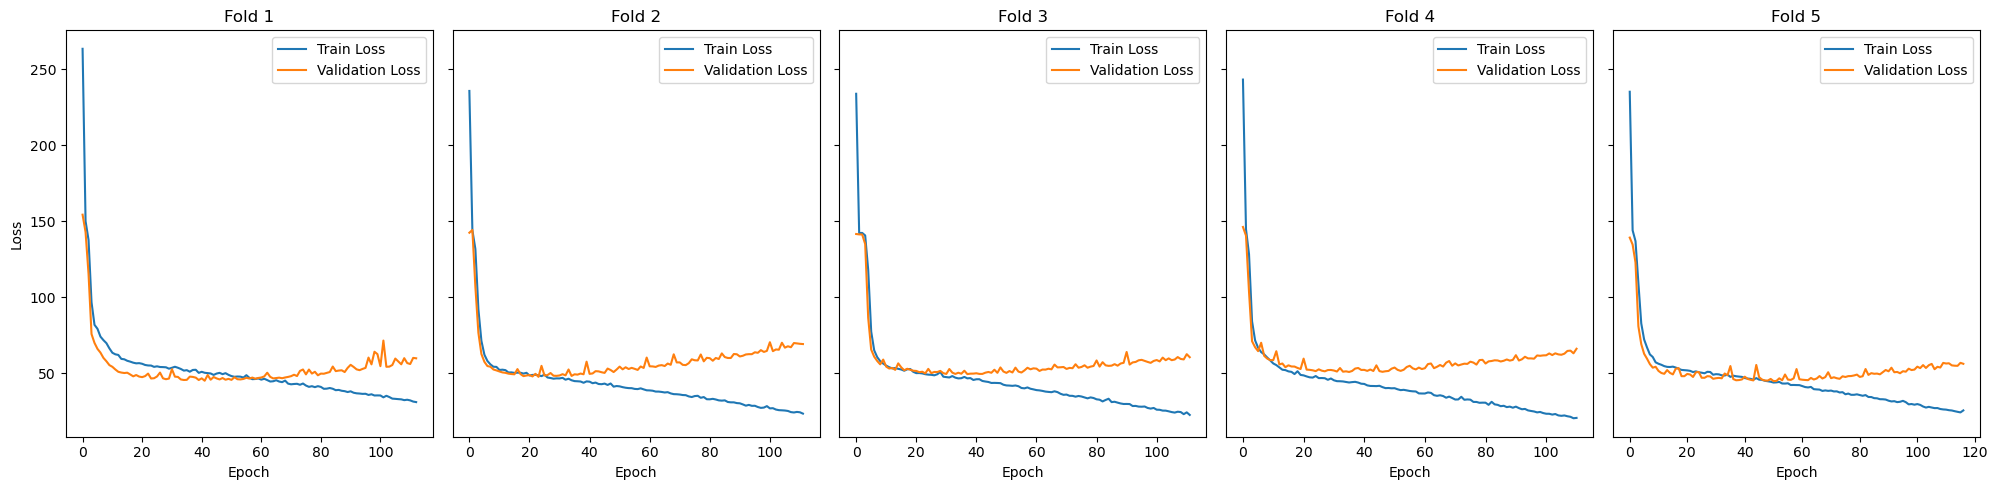

In [7]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 91
Best hyperparameters: {'learning_rate': 0.0001585574092876385, 'num_layers': 3, 'kernel_size': 3, 'pool_size': None, 'batch_size': 16, 'num_filters_layer_0': 64, 'num_filters_layer_1': 64, 'num_filters_layer_2': 32}
Validation Losses: [43.834, 45.598, 48.668, 48.939, 38.964]
Mean validation loss: 45.201
Test Losses: [60.161, 50.97, 55.507, 53.039, 56.482]
Mean test loss: 55.232
Mean test MAE: 5.526 std: 0.189
Mean test RMSE: 7.429 std: 0.21


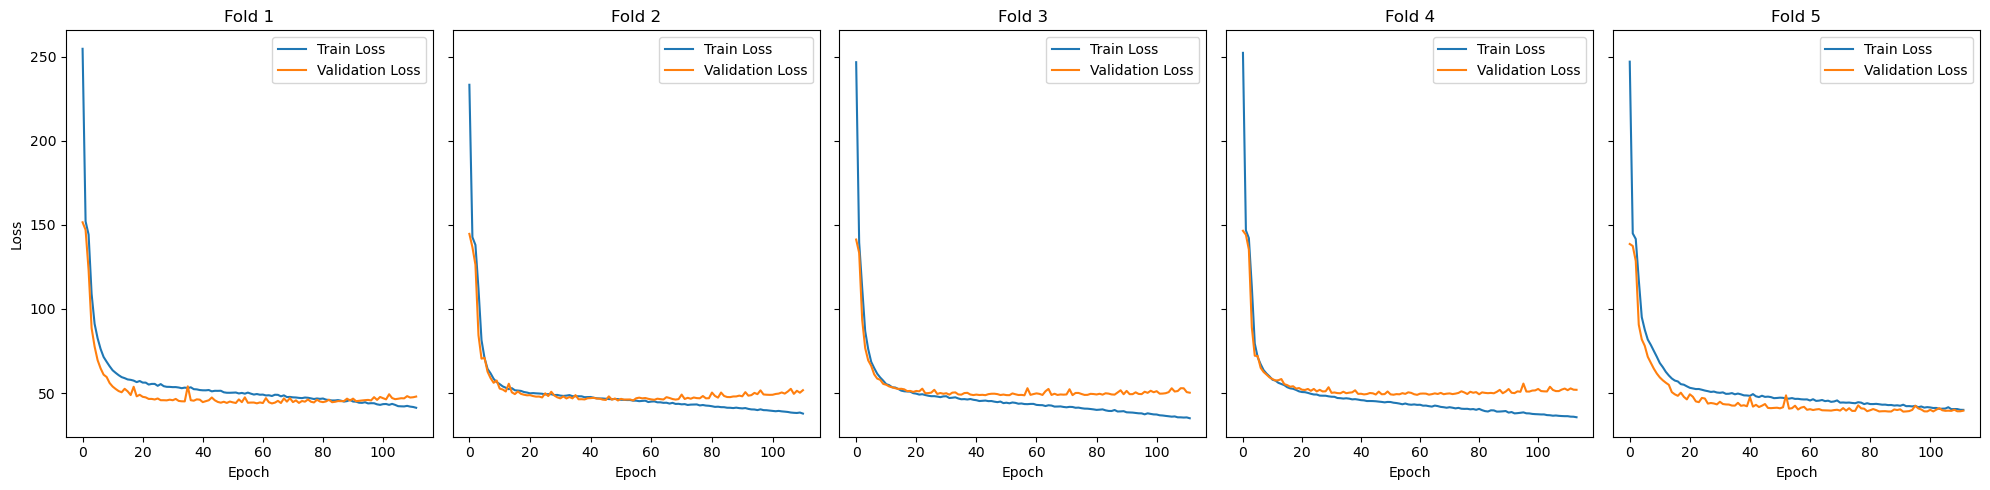

In [11]:
from models.cnn_pytorch import CNN
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNSeries_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None, 2, 3]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}


model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series, "X_mask": X_mask}
#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



Best hyperparameters: {'learning_rate': 0.0001585574092876385, 'num_layers': 3, 'kernel_size': 3, 'pool_size': None, 'batch_size': 16, 'num_filters_layer_0': 64, 'num_filters_layer_1': 64, 'num_filters_layer_2': 32}
Early stopping at epoch 112, with best epoch being 63
Early stopping at epoch 111, with best epoch being 54
Early stopping at epoch 112, with best epoch being 56
Early stopping at epoch 114, with best epoch being 59
Early stopping at epoch 112, with best epoch being 91
Validation Losses: [43.85864870548248, 45.56868350505829, 48.68392534255982, 48.97515063285827, 38.96025027036667]
Mean validation loss: 45.209331691265106
Test Losses: [60.16610845565796, 50.98682662963867, 55.52576131820679, 52.99226234436035, 56.51547348022461]
Mean test loss: 55.23728644561767


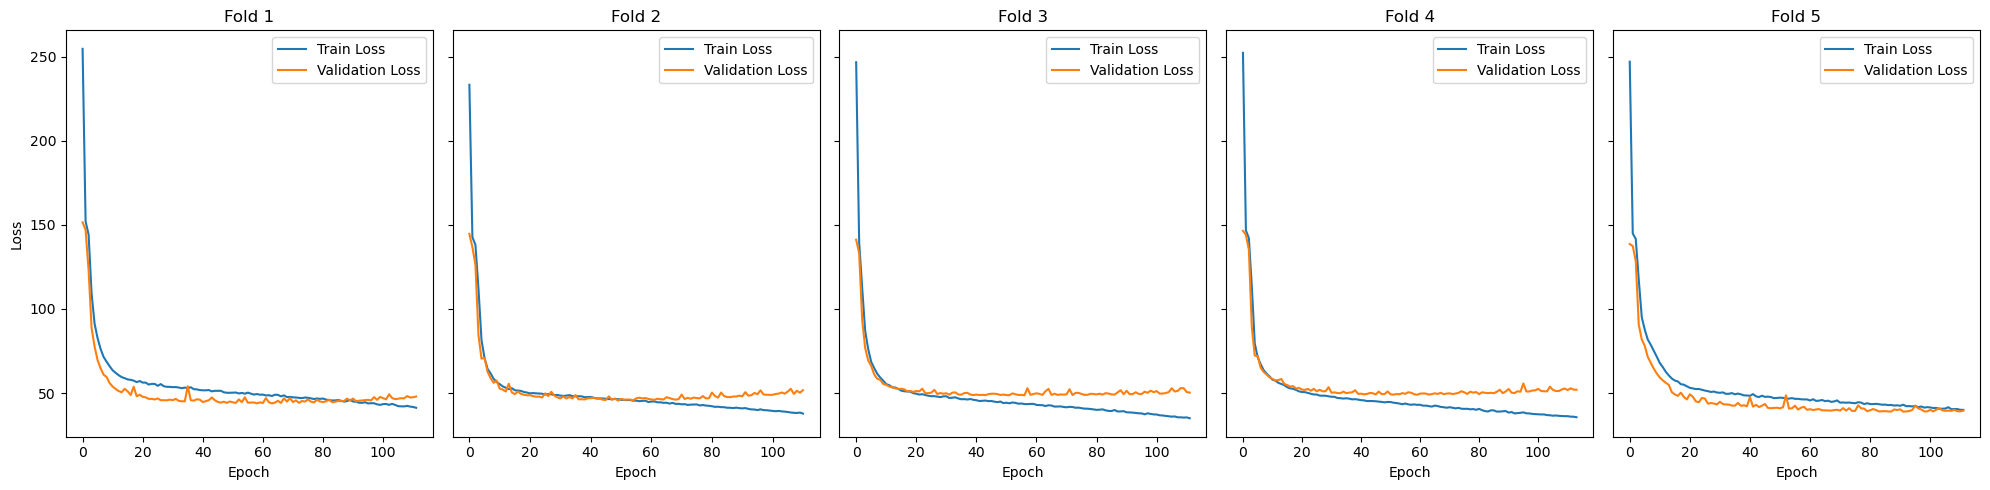

In [12]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 65
Best hyperparameters: {'learning_rate': 0.0008468028271167256, 'num_layers': 4, 'kernel_size': 5, 'pool_size': None, 'batch_size': 16, 'num_filters_layer_0': 16, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64, 'num_filters_layer_3': 32}
Validation Losses: [44.231, 40.08, 38.579, 44.787, 41.073]
Mean validation loss: 41.75
Test Losses: [46.196, 58.47, 49.916, 44.024, 50.968]
Mean test loss: 49.915
Mean test MAE: 5.838 std: 0.412
Mean test RMSE: 7.057 std: 0.346


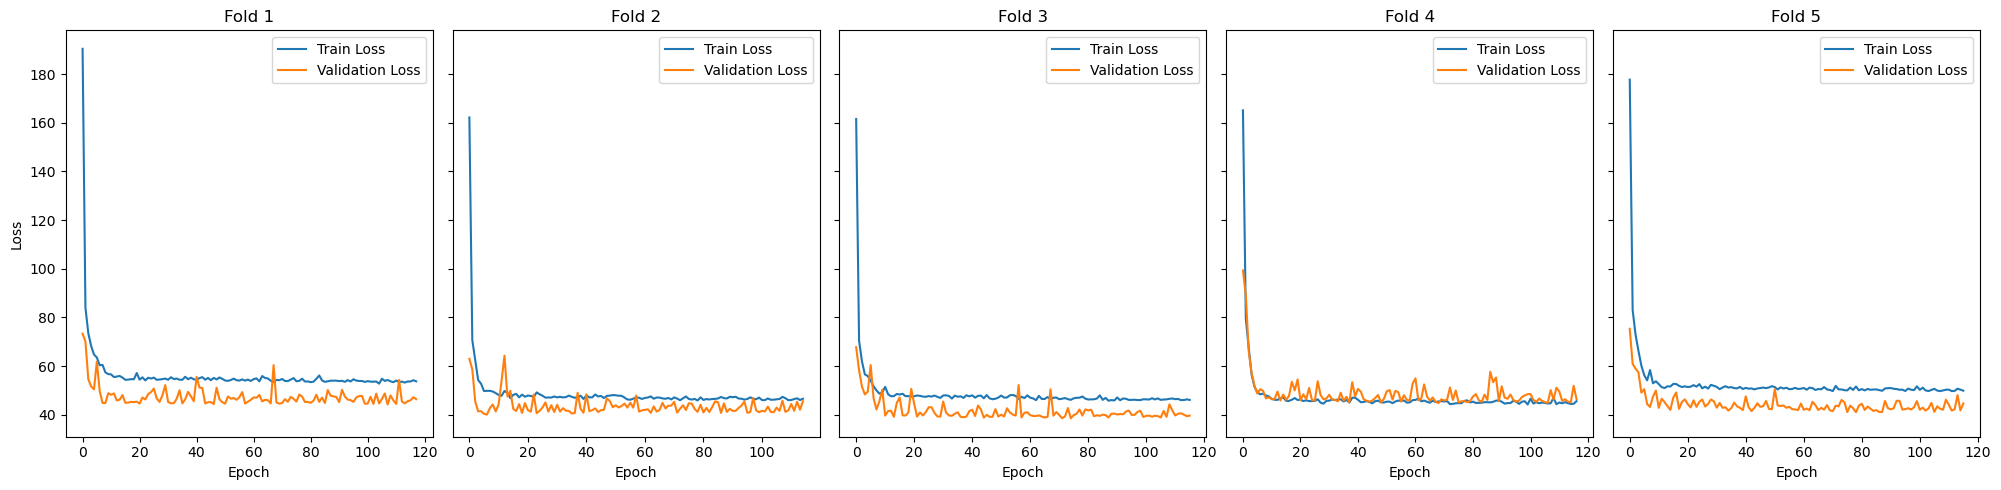

In [8]:
from models.cnn_pytorch import CNN
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "CNN"
model_name = "CNNIndexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]]
    },
    "kernel_size": {
        "type": "categorical",
        "args": [[3, 5, 7]]
    },
    "pool_size": {
        "type": "categorical",
        "args": [[None]]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["kernel_size", "num_filters_list", "pool_size"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

X = {"X_indices": X_indices}
#run_optuna_study(pipeline.run_cross_val, CNN, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)


Best hyperparameters: {'learning_rate': 0.0008468028271167256, 'num_layers': 4, 'kernel_size': 5, 'pool_size': None, 'batch_size': 16, 'num_filters_layer_0': 16, 'num_filters_layer_1': 64, 'num_filters_layer_2': 64, 'num_filters_layer_3': 32}
Early stopping at epoch 118, with best epoch being 107
Early stopping at epoch 115, with best epoch being 6
Early stopping at epoch 116, with best epoch being 74
Early stopping at epoch 117, with best epoch being 68
Early stopping at epoch 116, with best epoch being 78
Validation Losses: [44.18503029346466, 40.06846271157265, 38.58331456184387, 44.78733289241791, 41.06268974542618]
Mean validation loss: 41.737366040945055
Test Losses: [46.25610769271851, 58.403658056259154, 49.9584316444397, 43.97864654541016, 50.99657733917236]
Mean test loss: 49.91868425559998


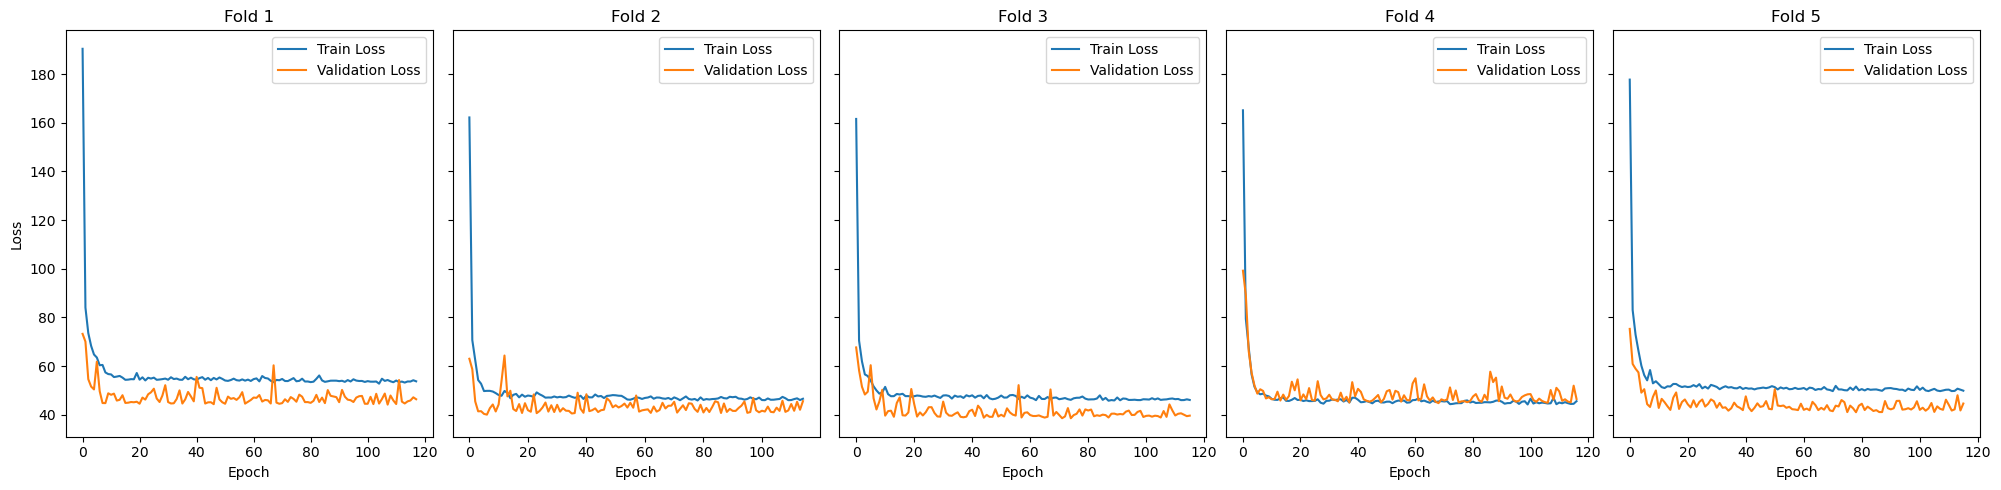

In [9]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


